# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [124]:
import numpy as np
import pandas as pd

# Viz mantra
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16., 9.)})
sns.set_style('whitegrid')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse

# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [2]:
# Run this code:

sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [3]:
sensor.head()


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [4]:
sensor.isna().sum()

attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

In [5]:
# There is no missing data

How many rows and columns are in our data?

In [6]:
sensor.shape

(1751, 12)

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [7]:
time_series = pd.date_range(start="1/1/2018 00:00:00", end="1/1/2018 00:29:10", periods=sensor.shape[0])
time_series.freq = pd.infer_freq(time_series)
time_series

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:00:01',
               '2018-01-01 00:00:02', '2018-01-01 00:00:03',
               '2018-01-01 00:00:04', '2018-01-01 00:00:05',
               '2018-01-01 00:00:06', '2018-01-01 00:00:07',
               '2018-01-01 00:00:08', '2018-01-01 00:00:09',
               ...
               '2018-01-01 00:29:01', '2018-01-01 00:29:02',
               '2018-01-01 00:29:03', '2018-01-01 00:29:04',
               '2018-01-01 00:29:05', '2018-01-01 00:29:06',
               '2018-01-01 00:29:07', '2018-01-01 00:29:08',
               '2018-01-01 00:29:09', '2018-01-01 00:29:10'],
              dtype='datetime64[ns]', length=1751, freq='S')

Assign the time series index to the dataframe's index.

In [10]:
sensor["Date"] = time_series
sensor.set_index('Date', inplace=True)
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
Date,,,,,,,,,,,,
2018-01-01 00:00:00,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
2018-01-01 00:00:01,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2018-01-01 00:00:02,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
2018-01-01 00:00:03,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
2018-01-01 00:00:04,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

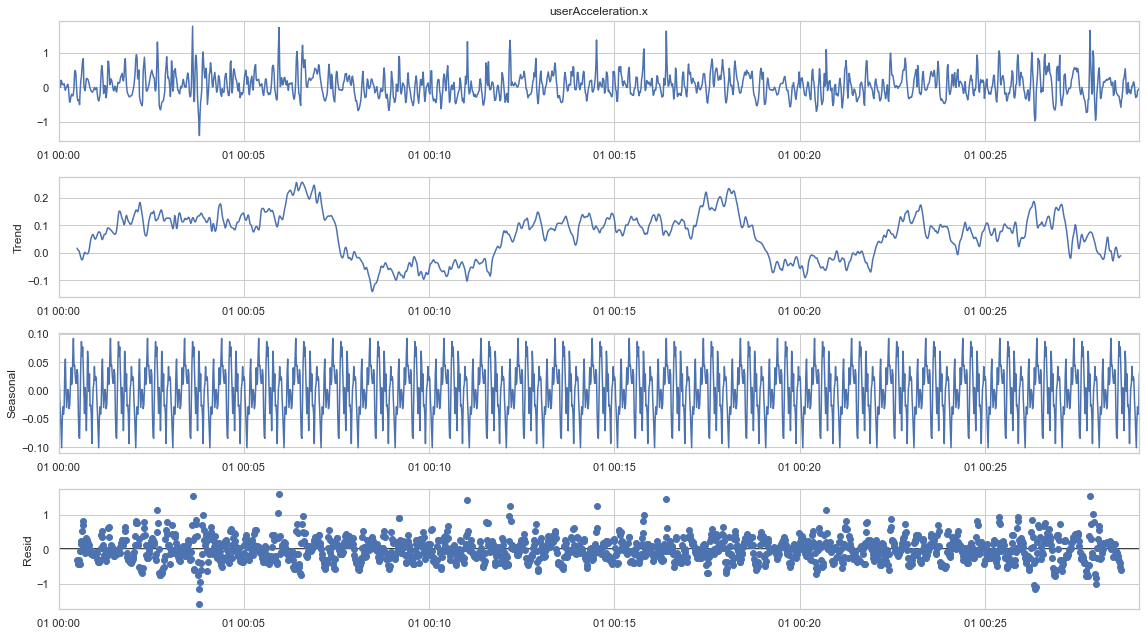

In [23]:
freq=60
res = seasonal_decompose(sensor["userAcceleration.x"], model="additive", period=freq)
res.plot();

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

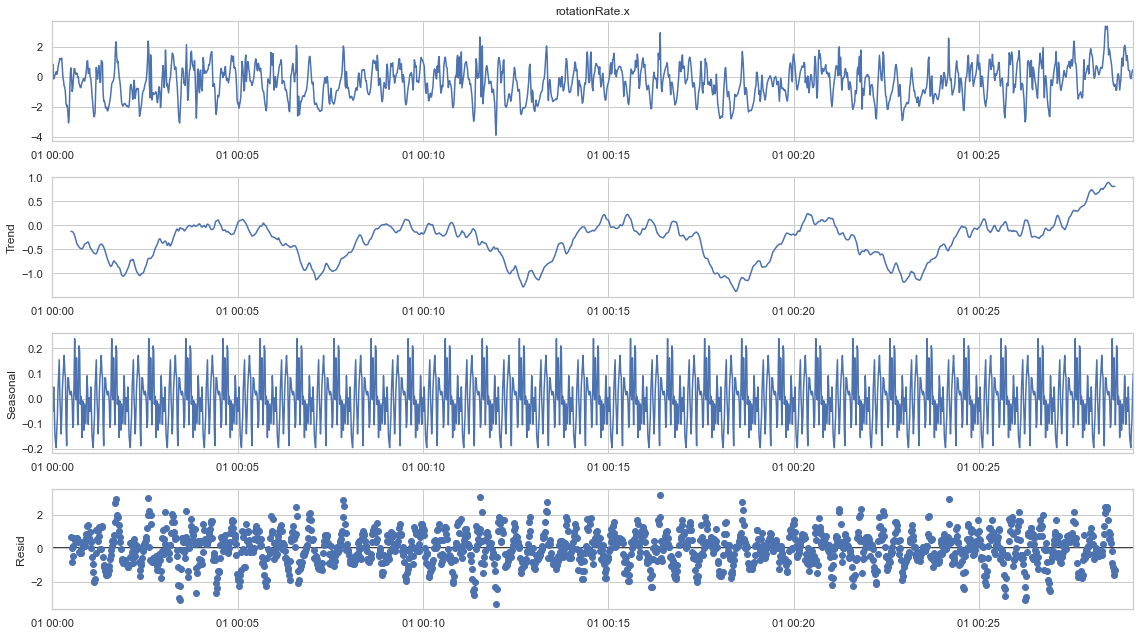

In [24]:
freq=60
res2 = seasonal_decompose(sensor["rotationRate.x"], model="additive", period=freq)
res2.plot();

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

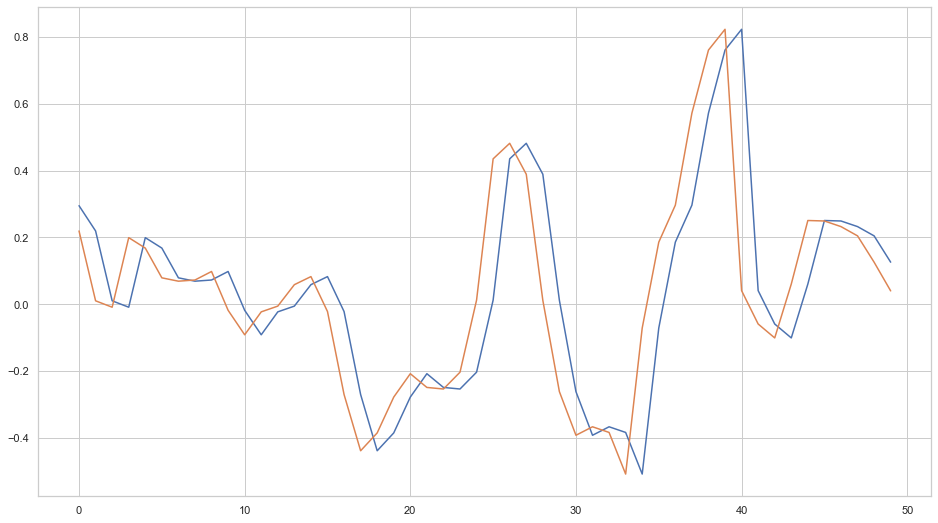

In [77]:
no_lag = sensor["userAcceleration.x"]
lag = sensor["userAcceleration.x"][1:]
plt.plot(no_lag.values[:50])
plt.plot(lag.values[:50])

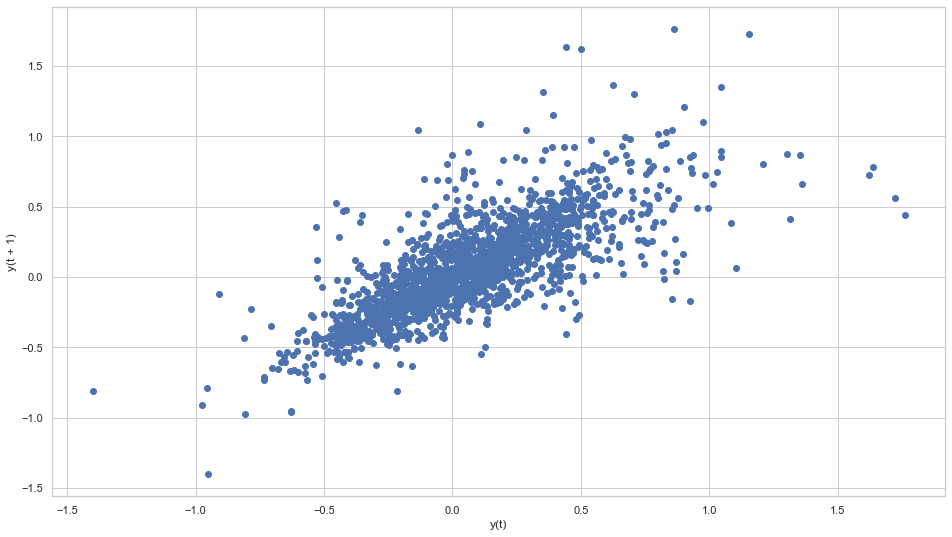

In [184]:
pd.plotting.lag_plot(sensor["userAcceleration.x"], lag=1);

Create a lag plot for `rotationRate.x`

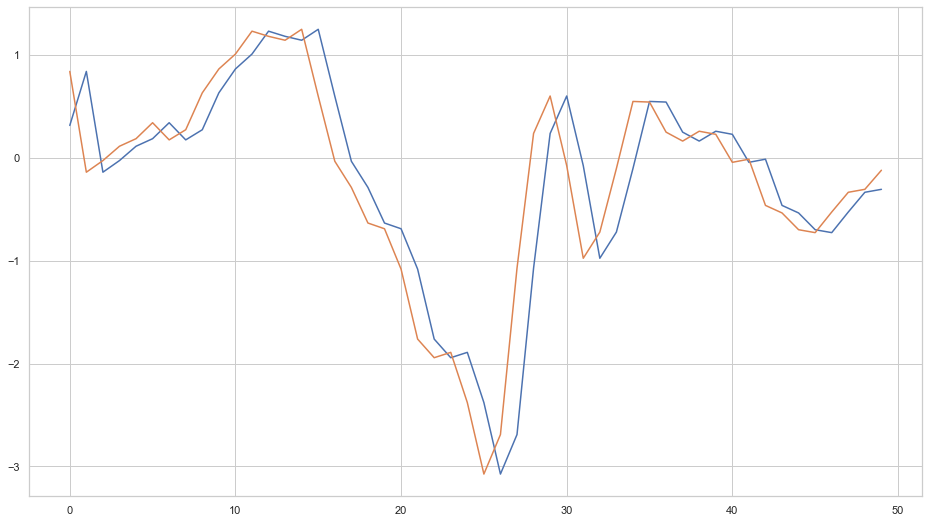

In [64]:
no_lag = sensor["rotationRate.x"]
lag = sensor["rotationRate.x"][1:]
plt.plot(no_lag.values[:50])
plt.plot(lag.values[:50])

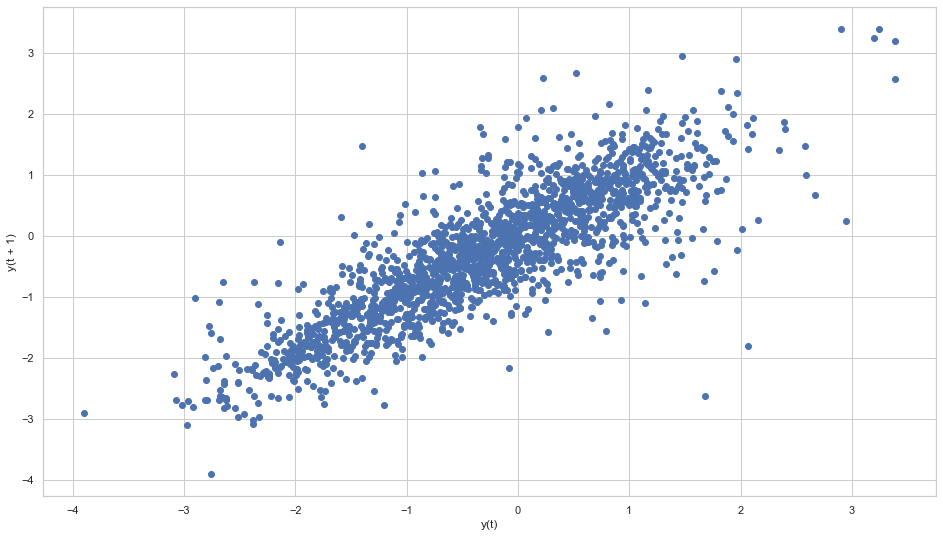

In [44]:
pd.plotting.lag_plot(sensor["rotationRate.x"], lag=1);


What are your conclusions from both visualizations?

In [78]:
# We can conclude that both variables have (not so strong) correlation when the lag is set to 1 but -
# they lose it if we increase the lag.


The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

- $H_0$ (Null Hypothesis) : The series is not stationary and there is a statistically significant trend

- $H_A$ (Alternative hypothesis) : The series is stationary

In [82]:
stationary_test1 = adfuller(sensor["userAcceleration.x"])
stationary_test1[1] # The p_value

2.823439483037483e-30

In [86]:
if stationary_test1[1] < 0.05:
    print("Rejection of H0. Keep the alternative: The series is stationary")
if stationary_test1[1] > 0.05:
    print("We don't have enough evidence to reject H0, The series is not stationary and there is a statistically significant trend.")

Rejection of H0. Keep the alternative: The series is stationary


In [83]:
stationary_test2 = adfuller(sensor["rotationRate.x"])
stationary_test2[1] # The p_value

6.320230335912605e-06

In [87]:
if stationary_test2[1] < 0.05:
    print("Rejection of H0. Keep the alternative: The series is stationary")
if stationary_test2[1] > 0.05:
    print("We don't have enough evidence to reject H0, The series is not stationary and there is a statistically significant trend.")

Rejection of H0. Keep the alternative: The series is stationary


What are your conclusions from this test?

In [88]:
# Since the p_value for both tests is very small we reject the null hypothesis so:
# Both variables are stationary

## Bonus: Challenge 2

Finally, we'll create an ARIMA model for `userAcceleration.x`. Load the `ARIMA` function from `statsmodels`. The order of the model is (2, 0, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [193]:
order = (2, 0, 1)

In [194]:
# 0. Splitting into train & test
y_train = sensor["userAcceleration.x"][:-10]
y_test = sensor["userAcceleration.x"][-11:]

In [195]:
# 1. Create an instance of the ARIMA model that takes y_train, the order, and freq="S"
# Docs: https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html
model = ARIMA(y_train, order=order, freq="S")

C:\Users\Marc\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  self._init_dates(dates, freq)


In [196]:
# 2. Fit the model:
model = model.fit()


In [197]:
# 3. Predict: create y_pred:
y_pred = model.predict(start=len(y_train), end=len(y_train)+10)

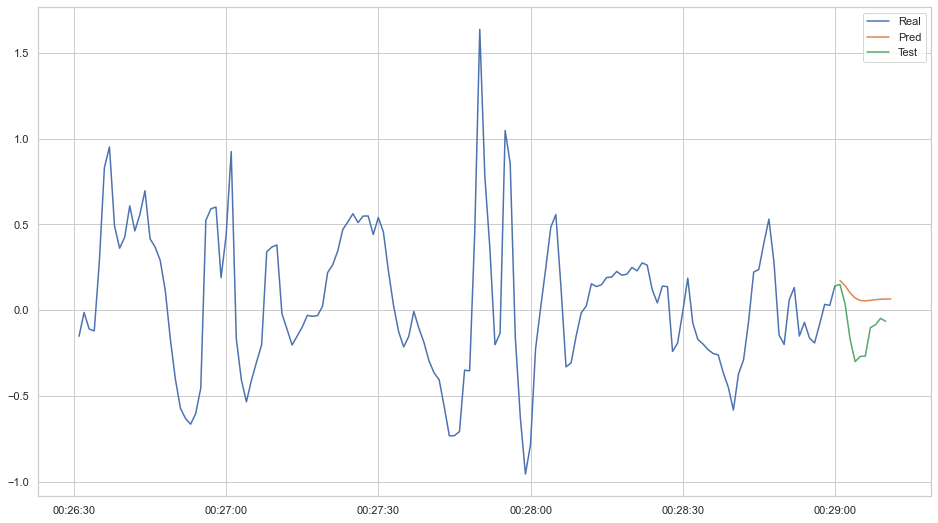

In [198]:
# 4. Visualize
plt.plot(y_train[-150:], label = "Real")
plt.plot(y_pred[-150:], label = "Pred")
plt.plot(y_test, label = "Test")
plt.legend()

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [199]:
# Your code here:
rmse(y_pred, y_test)

0.2085023469601176